Esta es una plantilla de modelo básica que se usará en la clase de CRM-Analytics de HackSpace Perú.

#### 84.61%

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import missingno as ms
pd.set_option('display.max_columns',None)

In [3]:
train = pd.read_csv('train_churn.csv')
test = pd.read_csv('test_churn.csv')

In [11]:
## Veamos los valores positivos y negativos de CHURN
train.to_csv('train_churn.csv', index=False)
test.to_csv('test_churn.csv',index=False)

#### Data exploration:

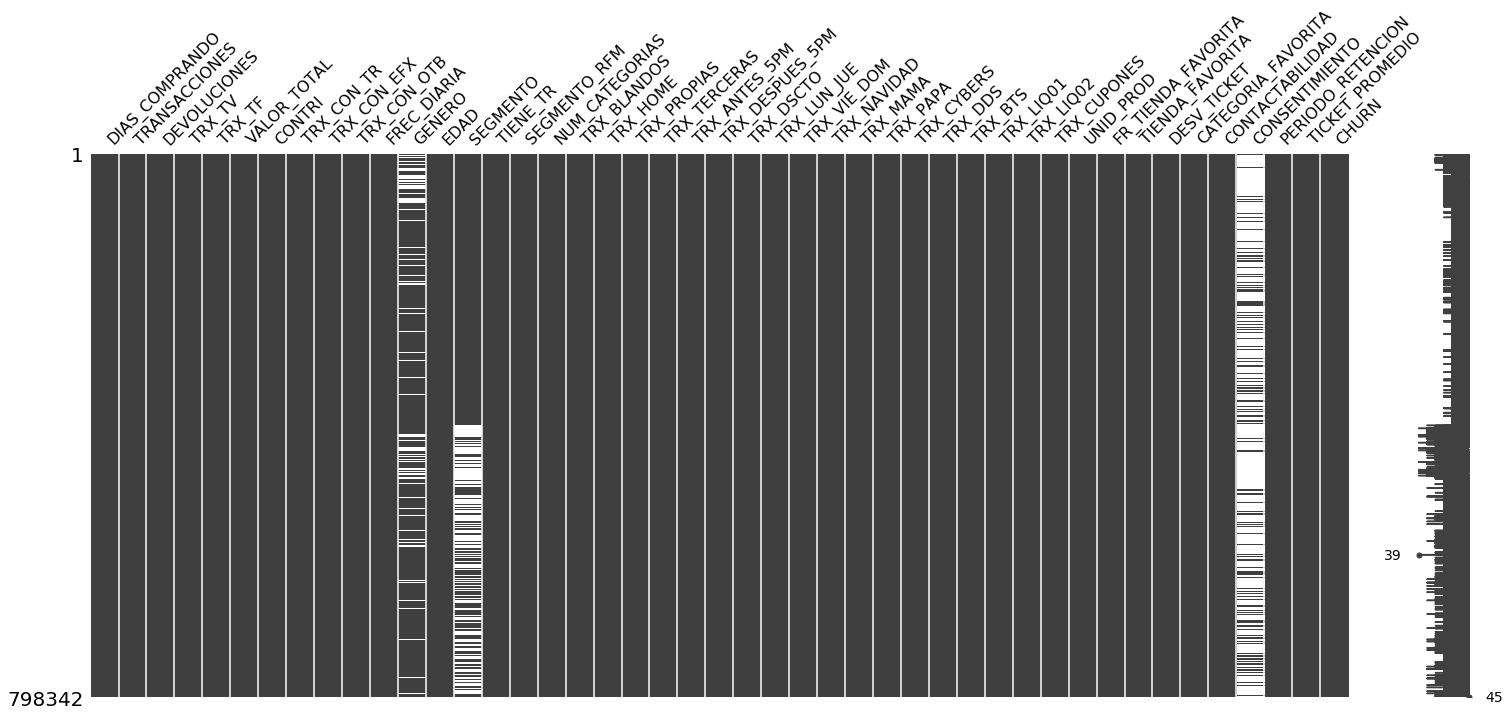

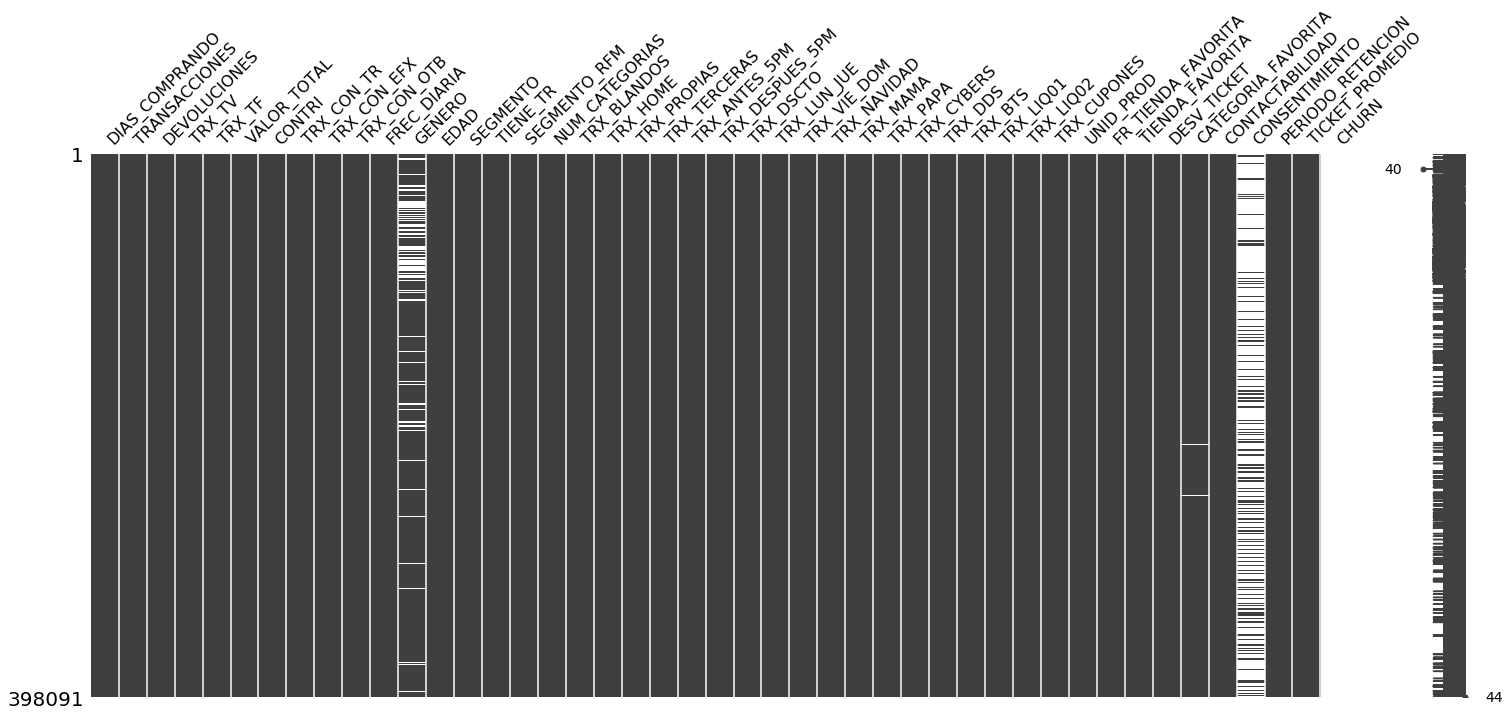

In [4]:
ms.matrix(train)
plt.show()
ms.matrix(test)
plt.show()

In [5]:
print('Porcentaje de nulos para segmento:\n TRAIN:{} \n TEST:{} '.format((train.SEGMENTO.isna().sum()/798342)*100,
                                                                      test.SEGMENTO.isna().sum()/798342))

print('Porcentaje de nulos para género:\n TRAIN:{} \n TEST:{} '.format((train.GENERO.isna().sum()/798342)*100,
                                                                      (test.GENERO.isna().sum()/798342)*100))

Porcentaje de nulos para segmento:
 TRAIN:24.999311072197127 
 TEST:0.0 
Porcentaje de nulos para género:
 TRAIN:11.690353257125393 
 TEST:7.64722387147363 


### Pequeña corrección de errores

In [9]:
train['SEGMENTO'] = train['SEGMENTO'].replace({
    '01.- GOLD':'GOLD',
    '02.- SILVER':'SILVER',
    '03.- BRONZE':'BRONZE',
    '04.- PABLOMART':'PABLOMART'
})

#### Reemplazo rápido de nulos

In [10]:
train['SEGMENTO'].fillna('Nulo',inplace=True)
train['GENERO'].fillna('NoProvee',inplace=True)

In [21]:
train.drop('CONSENTIMIENTO',axis=1,inplace=True)

In [26]:
col_nulos = []
for col in train.columns:
    if train[col].isna().any() == False:
        pass
    else:
        col_nulos.append(col)

In [48]:
for col in ['SEGMENTO_RFM','TIENDA_FAVORITA','CATEGORIA_FAVORITA','CONTACTABILIDAD']:
    train[col].fillna('Nulo',inplace=True)

In [49]:
train['EDAD'].fillna(train.EDAD.mean(),inplace=True)
train['FR_TIENDA_FAVORITA'].fillna(train.FR_TIENDA_FAVORITA.mode()[0],inplace=True)

#### Encoding basico: OneHotEncoding

In [62]:
#One Hot encoder con dummys
train = pd.get_dummies(train, columns = ['GENERO','SEGMENTO_RFM','TIENDA_FAVORITA','CONTACTABILIDAD','SEGMENTO',
                                         'TIENE_TR','CATEGORIA_FAVORITA','discr_valor_total','discr_contri',
                                         'discr_trx_dscto','valor_total_discreto','devoluciones_discreto',
                                         'Retencion_range'])

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798342 entries, 0 to 798341
Columns: 115 entries, DIAS_COMPRANDO to CATEGORIA_FAVORITA_OTROS
dtypes: float64(10), int64(27), uint8(78)
memory usage: 284.7 MB


### Benchmark básico:

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [65]:
X = train.drop('CHURN',axis=1)
y = train['CHURN']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [67]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

C:\Users\pablo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
accuracy_score(y_test,preds)

0.6660637519665707

In [70]:
for i in range(1,18):
    dt = DecisionTreeClassifier(max_depth= i)
    dt.fit(X_train,y_train)
    preds = dt.predict(X_test)
    print('Para un max_depth de ',i,'tienes un acc de ', accuracy_score(y_test,preds))

Para un max_depth de  1 tienes un acc de  0.7435140741334563
Para un max_depth de  2 tienes un acc de  0.7728447887126352
Para un max_depth de  3 tienes un acc de  0.8336506568596995
Para un max_depth de  4 tienes un acc de  0.8421632779854299
Para un max_depth de  5 tienes un acc de  0.8423937550730011
Para un max_depth de  6 tienes un acc de  0.8431052278215907
Para un max_depth de  7 tienes un acc de  0.8438367420560561
Para un max_depth de  8 tienes un acc de  0.8438918561422144
Para un max_depth de  9 tienes un acc de  0.8443177377170743
Para un max_depth de  10 tienes un acc de  0.8440722295150962
Para un max_depth de  11 tienes un acc de  0.8432254767368452
Para un max_depth de  12 tienes un acc de  0.8419929253554859
Para un max_depth de  13 tienes un acc de  0.8404647620574589
Para un max_depth de  14 tienes un acc de  0.838009680037678
Para un max_depth de  15 tienes un acc de  0.8365516619402162
Para un max_depth de  16 tienes un acc de  0.8334803042297556
Para un max_depth 

In [75]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=8, learning_rate=0.05, objective='binary:logistic',eval_metric='error',seed=122)

In [76]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=122,
              silent=None, subsample=1, verbosity=1)

In [77]:
preds_xgb = xgb.predict(X_test)

In [3]:
roc_auc_score(preds_xgb,y_test)

0.8456970665783634

## UTILITIES:

In [80]:
ls

 El volumen de la unidad C es Windows
 El n£mero de serie del volumen es: A808-BC75

 Directorio de C:\Users\pablo\OneDrive\Escritorio\CRM_hs

10/01/2020  21:02    <DIR>          .
10/01/2020  21:02    <DIR>          ..
10/01/2020  13:58    <DIR>          .ipynb_checkpoints
10/01/2020  01:46            13.037 dic%20datos.xlsx
08/01/2020  12:43               176 dic_purchaseBehavior.txt
09/01/2020  17:19             1.541 funct.py
07/01/2020  12:52       216.101.685 Hackchurn.csv
10/01/2020  20:46         1.626.271 Hackchurn.ipynb
10/01/2020  21:02           237.693 Hackchurn-BenchmarkB sico.ipynb
08/01/2020  12:43           459.875 PurchaseBehavior.csv
10/01/2020  11:05           975.959 qH007 (2020-01-09T17_00_00-05_00,2020-01-10T08_00_00-05_00).csv
10/01/2020  01:44           186.029 Review.ipynb
10/01/2020  21:08     5.069.408.182 session1.db
08/01/2020  13:05        67.641.411 test_churn.csv
08/01/2020  13:06       136.824.845 train_churn.csv
10/01/2020  12:03            40.501 Unt

In [88]:
dic = {'nombres':X.columns,'feature_importance': xgb.feature_importances_}

pd.DataFrame().from_dict(dic).sort_values('feature_importance',ascending=False).head(12)

,nombres,feature_importance
97,SEGMENTO_Nulo,0.407214
32,FR_TIENDA_FAVORITA,0.139650
34,PERIODO_RETENCION,0.118009
94,CONTACTABILIDAD_SI,0.085961
0,DIAS_COMPRANDO,0.072951
30,TRX_CUPONES,0.054685
38,GENERO_NoProvee,0.015611
1,TRANSACCIONES,0.006547
11,EDAD,0.006252
4,TRX_TF,0.003715


#### Analizando los errores de mi modelo

[]

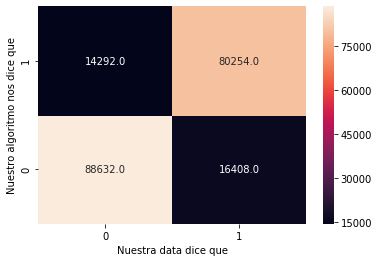

In [14]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test,preds_xgb)
ax=sns.heatmap(conf, annot = True, annot_kws={"size": 10}, fmt=".1f")
ax.set_ylim((0,2))
plt.xlabel('Nuestra data dice que')
plt.ylabel('Nuestro algoritmo nos dice que')
plt.plot()

In [16]:
80254/(80254+14292)

0.8488354874875722

- De lo siguiente tengo que mi modelo ha predicho como uno erróneamente 16408 veces. Osea, mi modelo ha dicho que se van a fugar cuando en realidad no lo van a hacer 16408 veces. 

- Mi modelo ha dicho que no se van a fugar 14292 cuando sí lo van a hacer. **Esta es la métrica que más debería cuidar**.


### Mi modelo debería: 

- **Evitar los Falsos negativos!!** Con este modelo serían 14292 clientes menos!!!! Esto también se puede decir como que quiero **mejorar la SENSITIVIDAD** y **priorizar los True Positives** 

In [11]:
pd.crosstab(y_test, preds_xgb, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,88632,16408,105040
1.0,14292,80254,94546
All,102924,96662,199586


In [18]:
from sklearn.metrics import recall_score
recall_score(y_test,preds_xgb)

0.8488354874875722